# 可视化模型的 Scale&Shift 参数
## ViT-b16

In [1]:
%cd /home/zxy/SSF
import sys
import os
PROJECT_ROOT="/home/wyh/PEFT/SSF"
PROJECT_ROOT="/home/wyh/SSF"
SAVED_ROOT="/media/disk1/wyh/SSF"
sys.path.append(PROJECT_ROOT)
import torch
import timm
from timm.models import create_model, safe_model_name, resume_checkpoint, load_checkpoint,\
    convert_splitbn_model, model_parameters
from models import vision_transformer, swin_transformer, convnext, as_mlp
from models.lora import LoRA_ViT_timm
import numpy as np


/home/zxy/SSF


In [2]:
MODEL_NAME="vit_base_patch16_224_in21k"
MODEL_PATH="/data/hjy/SSF/vit_base_patch16_224_in21k/vtab/clevr_dist/pruning_rec_loss/20230813-120429-vit_base_patch16_224_in21k-224/last.pth.tar"
cd0="/data/hjy/SSF/vit_base_patch16_224_in21k/vtab/clevr_dist/rec=0.8_26.03_250.pth.tar"
cd1="/data/hjy/SSF/vit_base_patch16_224_in21k/vtab/clevr_dist/full-45.35-230.pth.tar"
cd2="/data/hjy/SSF/vit_base_patch16_224_in21k/vtab/clevr_dist/pruning_retrain_lora/20230814-071421-vit_base_patch16_224_in21k-224/checkpoint-42.pth.tar"
METHOD_NAME="ssf"
NUM_CLASSES=6

In [3]:
def get_scale_dict(path):
    model = create_model(
        MODEL_NAME,
        pretrained=True,
        num_classes=NUM_CLASSES,
        drop_rate=0.0,
        drop_path_rate=0.0,
        drop_block_rate=None,
        global_pool=None,
        bn_momentum=None,
        bn_eps=None,
        scriptable=False,
        checkpoint_path='',
        tuning_mode=METHOD_NAME)
    resume_epoch = resume_checkpoint(
        model, path,
        optimizer=None,
        loss_scaler=None,
        log_info=True)
    
    ssf_scale,ssf_scale_masked={},{}
    for name, para in model.named_parameters():
        if "ssf_scale" in name:
            temp=para.data.detach().cpu().numpy()
            ssf_scale[name]=temp
            ssf_scale_masked[name]=temp[temp!=0]
    return  ssf_scale,ssf_scale_masked



In [4]:
def get_from_ckpt(path):
    ckpt = torch.load(path, map_location='cpu')
    state_dict=ckpt['state_dict']
    ssf_scale,ssf_scale_masked={},{}
    for (name,para) in state_dict.items():
        if 'ssf_scale' in name:
            temp=para.data.detach().cpu().numpy()
            ssf_scale[name]=temp
            ssf_scale_masked[name]=temp[temp!=0]
    return  ssf_scale,ssf_scale_masked

In [5]:
cd_0,cd_0_masked=get_scale_dict(cd0)
cd_1,cd_1_masked=get_scale_dict(cd1)
cd_2,cd_2_masked=get_from_ckpt(cd2)

In [6]:
import warnings
warnings. filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision.models as models

def draw(dict):
    arr,name=[],[]
    for key,val in dict.items():
        name.append(key)
        arr.append(val)
    up_mean=np.mean(np.array([a.max() for a in arr]))
    lw_mean=np.mean(np.array([a.min() for a in arr]))
    num_rows = len(arr)
    fig, axs = plt.subplots(ncols=num_rows, nrows=1, sharey=True,gridspec_kw={"hspace": 0, "wspace": 0})
    fig.set_size_inches(20, 4)
    lw=lw_mean*1.5 if lw_mean<0 else lw_mean*0.5
    ran=(lw,up_mean*1.5)
    ran=(lw,up_mean*1.5)
    for i in range(num_rows):
        # sns.histplot(y=arr[i], ax=axs[i], kde=True, stat="density")
        # sns.distplot(arr[i], ax=axs[i], kde=True, stat="density",hist_kws={'range': (0.0, 0.2)})
        color="blue"
        if arr[i].max() > up_mean*1.2 or arr[i].min() < lw_mean*0.8:
            color="red"
        sns.distplot(arr[i], ax=axs[i], kde=True, vertical=True,color=color)
        # sns.distplot(arr[i], ax=axs[i], kde=True, vertical=True,color=color,\
        #     hist_kws={'range': ran},kde_kws={'clip': ran})
        # sns.histplot(data, clip=(0, 10))
        axs[i].set_xticks([])
        # axs[i].set_xlabel(f"{i+1}")
        label=""
        if 'attn' in name[i]:
            label+="a"
        elif 'mlp' in name[i]:
            label+="m"
        else:
            label+="b"
        label+=name[i].split("_")[-1]
        axs[i].set_xlabel(label)
    plt.tight_layout()
    # sns.set_style('white')
    sns.set(style='whitegrid')
    sns.despine(right=True,left=True)
    plt.show()
    print("MAX Scale: ", max([s.max() for s in arr]))
    print("MIN Scale: ", min([s.min() for s in arr]))
    print("AVE Scale: ", sum([sum(s) for s in arr])/sum([len(s) for s in arr]))


In [7]:
# print(type(cd_0))
def max_min_ave_var(dict):
    list=[]
    for name,val in dict.items():
        print(f'{name:30} Len:{val.shape[0]:5}   Max:{max(val):2.3f}   Min:{min(val):2.3f}  Ave:{np.mean(val):2.3f}  Var:{np.var(val):2.3f}')
        list.append(val)
    list=np.hstack(list)
    print("MAX Scale: ", list.max())
    print("MIN Scale: ", list.min())
    print("AVE Scale: ", np.mean(list))
    print("VAR Scale: ", np.var(list))

In [12]:
def draw_and_max_min_ave_var(dict):
    draw(dict)
    max_min_ave_var(dict)

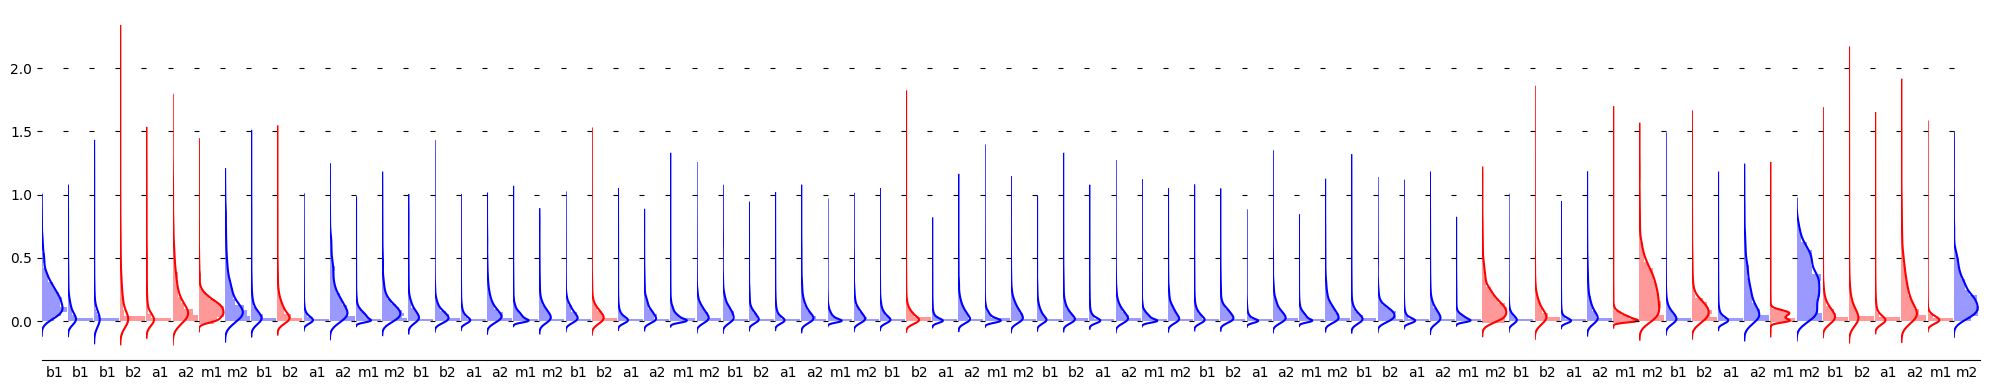

MAX Scale:  2.1520452
MIN Scale:  -0.081743754
AVE Scale:  0.06924928461805892


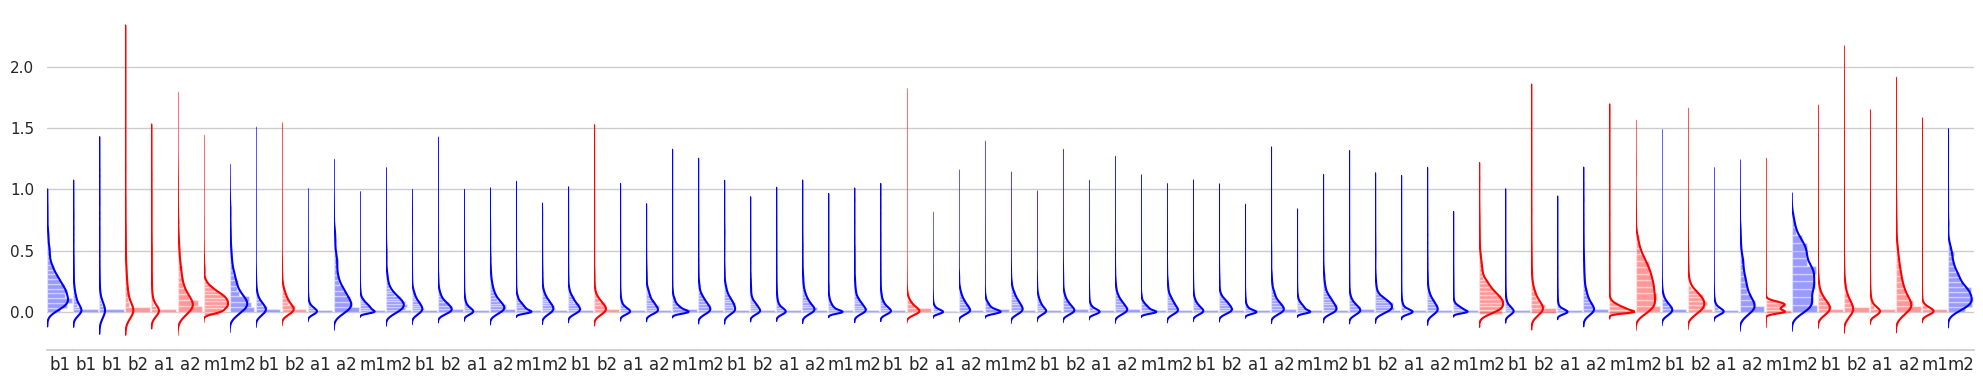

MAX Scale:  2.1520452
MIN Scale:  -0.081743754
AVE Scale:  0.06924928461805892


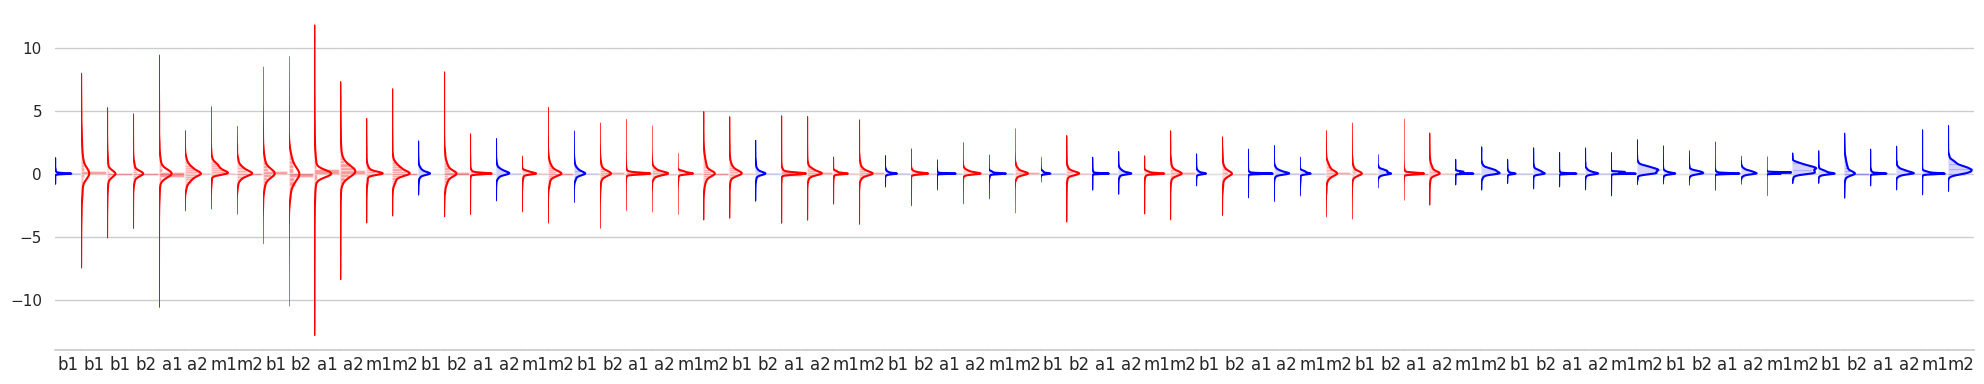

MAX Scale:  10.912936
MIN Scale:  -11.957451
AVE Scale:  0.0688380641881067


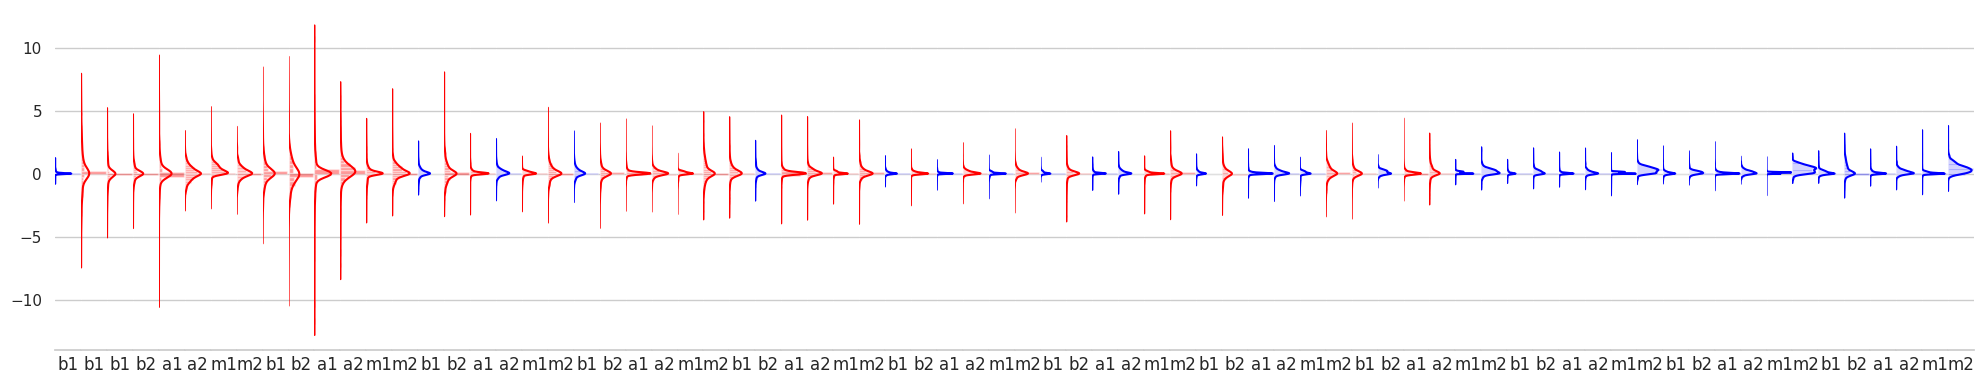

MAX Scale:  10.912936
MIN Scale:  -11.957451
AVE Scale:  0.07408689369203875


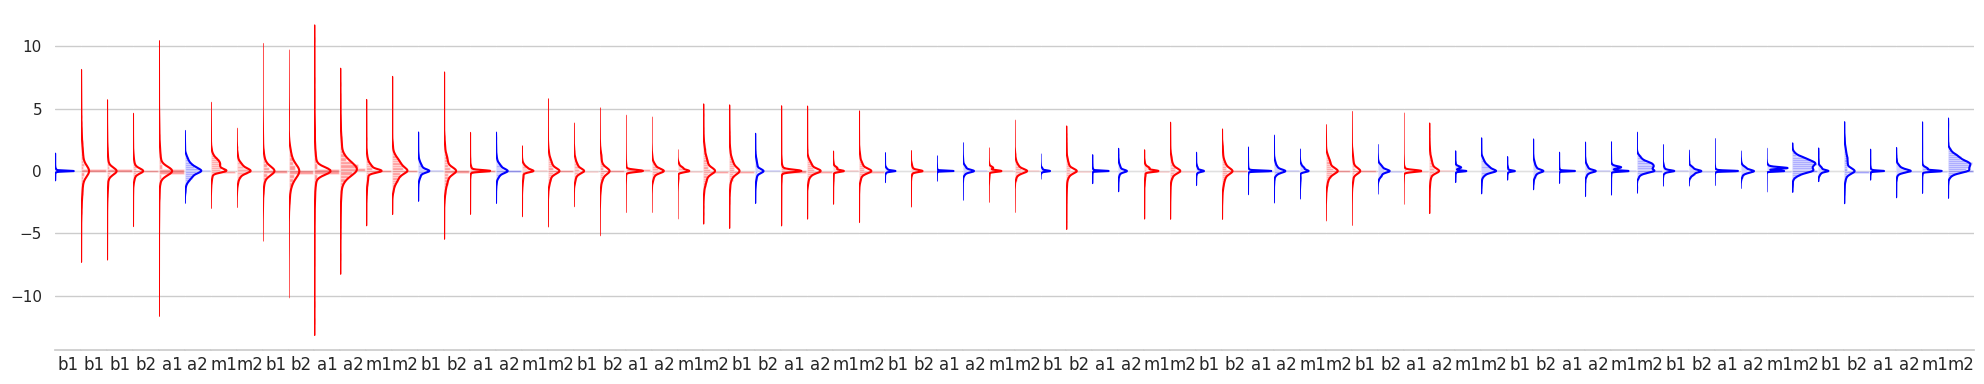

MAX Scale:  10.76842
MIN Scale:  -12.237313
AVE Scale:  0.08465003969637845


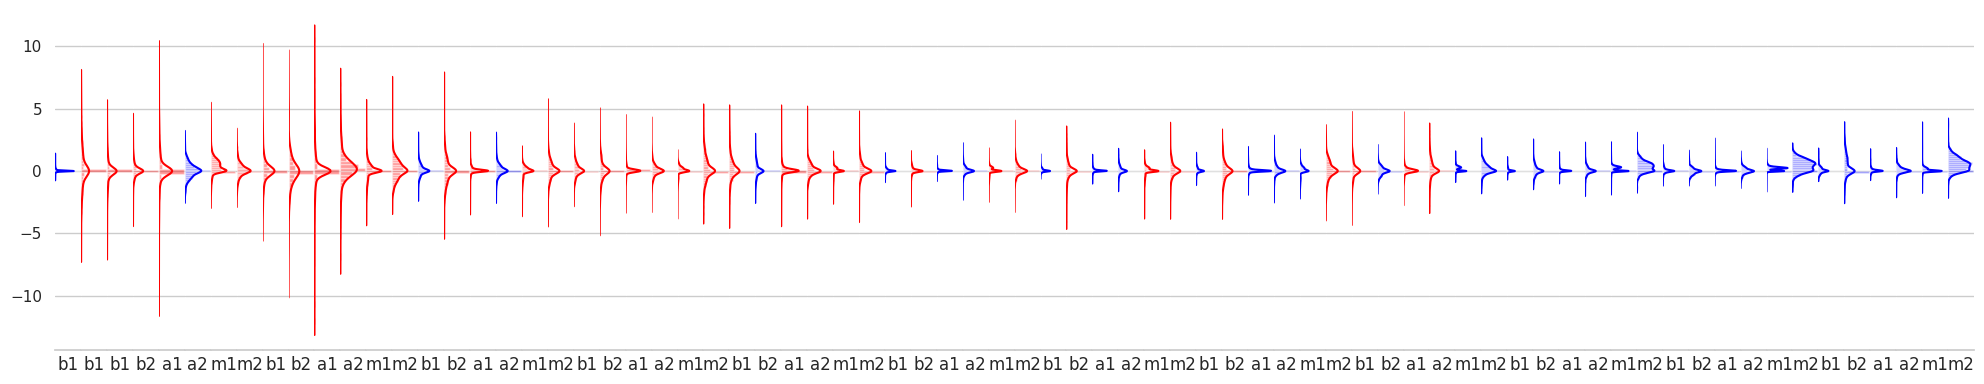

MAX Scale:  10.76842
MIN Scale:  -12.237313
AVE Scale:  0.09226041203132392


In [10]:
draw(cd_0)
draw(cd_0_masked)
draw(cd_1)
draw(cd_1_masked)
draw(cd_2)
draw(cd_2_masked)

==============================Reg+Rec======================


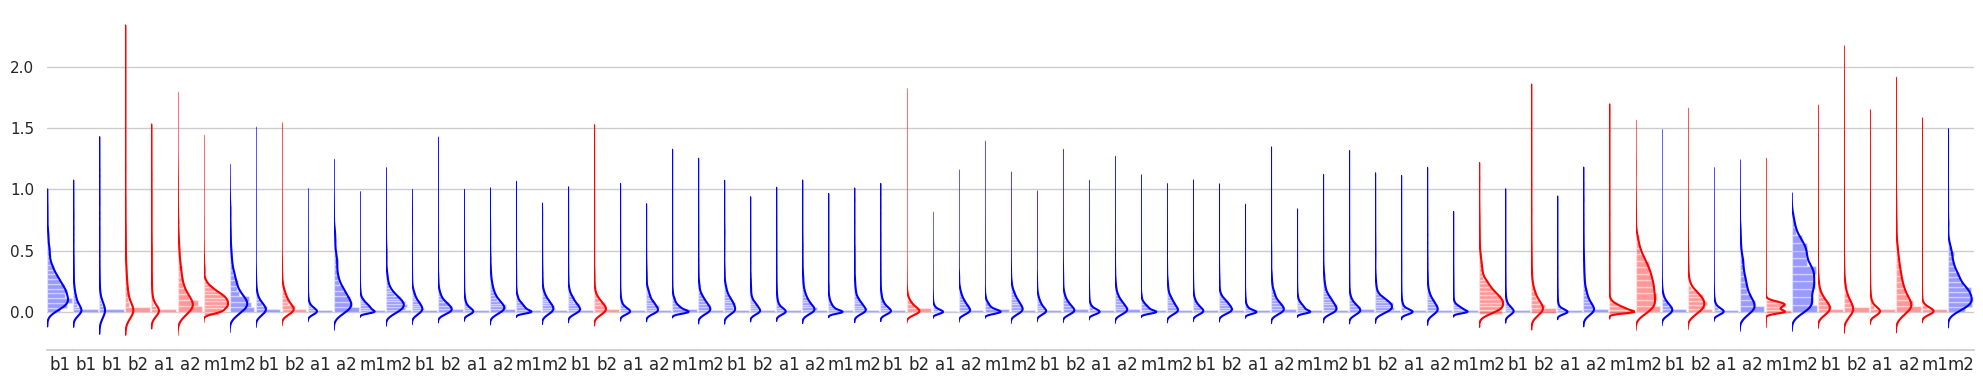

MAX Scale:  2.1520452
MIN Scale:  -0.081743754
AVE Scale:  0.06924928461805892
ssf_scale_1                    Len:  768   Max:0.886   Min:-0.000  Ave:0.197  Var:0.021
patch_embed.ssf_scale_1        Len:  768   Max:0.954   Min:-0.000  Ave:0.090  Var:0.022
blocks.0.ssf_scale_1           Len:  768   Max:1.252   Min:-0.000  Ave:0.100  Var:0.048
blocks.0.ssf_scale_2           Len:  768   Max:2.152   Min:-0.000  Ave:0.132  Var:0.052
blocks.0.attn.ssf_scale_1      Len: 2304   Max:1.398   Min:-0.000  Ave:0.106  Var:0.042
blocks.0.attn.ssf_scale_2      Len:  768   Max:1.606   Min:-0.000  Ave:0.200  Var:0.053
blocks.0.mlp.ssf_scale_1       Len: 3072   Max:1.380   Min:-0.022  Ave:0.109  Var:0.009
blocks.0.mlp.ssf_scale_2       Len:  768   Max:1.042   Min:-0.000  Ave:0.191  Var:0.041
blocks.1.ssf_scale_1           Len:  768   Max:1.385   Min:-0.000  Ave:0.080  Var:0.023
blocks.1.ssf_scale_2           Len:  768   Max:1.435   Min:-0.000  Ave:0.089  Var:0.018
blocks.1.attn.ssf_scale_1      Len: 2304 

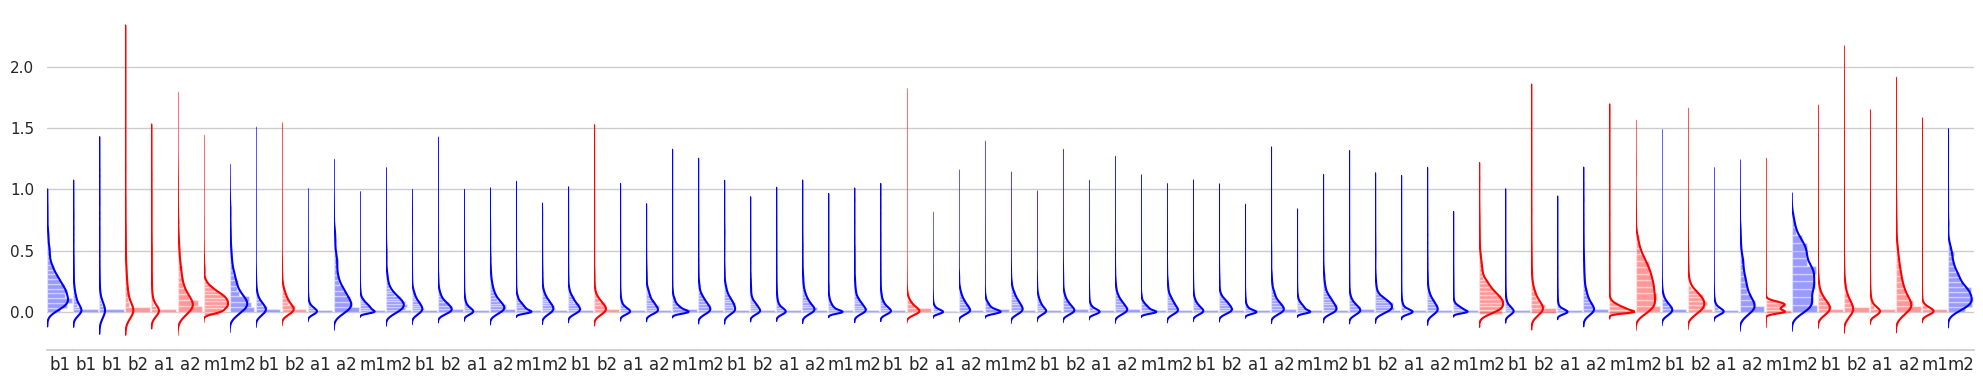

MAX Scale:  2.1520452
MIN Scale:  -0.081743754
AVE Scale:  0.06924928461805892
ssf_scale_1                    Len:  768   Max:0.886   Min:-0.000  Ave:0.197  Var:0.021
patch_embed.ssf_scale_1        Len:  768   Max:0.954   Min:-0.000  Ave:0.090  Var:0.022
blocks.0.ssf_scale_1           Len:  768   Max:1.252   Min:-0.000  Ave:0.100  Var:0.048
blocks.0.ssf_scale_2           Len:  768   Max:2.152   Min:-0.000  Ave:0.132  Var:0.052
blocks.0.attn.ssf_scale_1      Len: 2304   Max:1.398   Min:-0.000  Ave:0.106  Var:0.042
blocks.0.attn.ssf_scale_2      Len:  768   Max:1.606   Min:-0.000  Ave:0.200  Var:0.053
blocks.0.mlp.ssf_scale_1       Len: 3072   Max:1.380   Min:-0.022  Ave:0.109  Var:0.009
blocks.0.mlp.ssf_scale_2       Len:  768   Max:1.042   Min:-0.000  Ave:0.191  Var:0.041
blocks.1.ssf_scale_1           Len:  768   Max:1.385   Min:-0.000  Ave:0.080  Var:0.023
blocks.1.ssf_scale_2           Len:  768   Max:1.435   Min:-0.000  Ave:0.089  Var:0.018
blocks.1.attn.ssf_scale_1      Len: 2304 

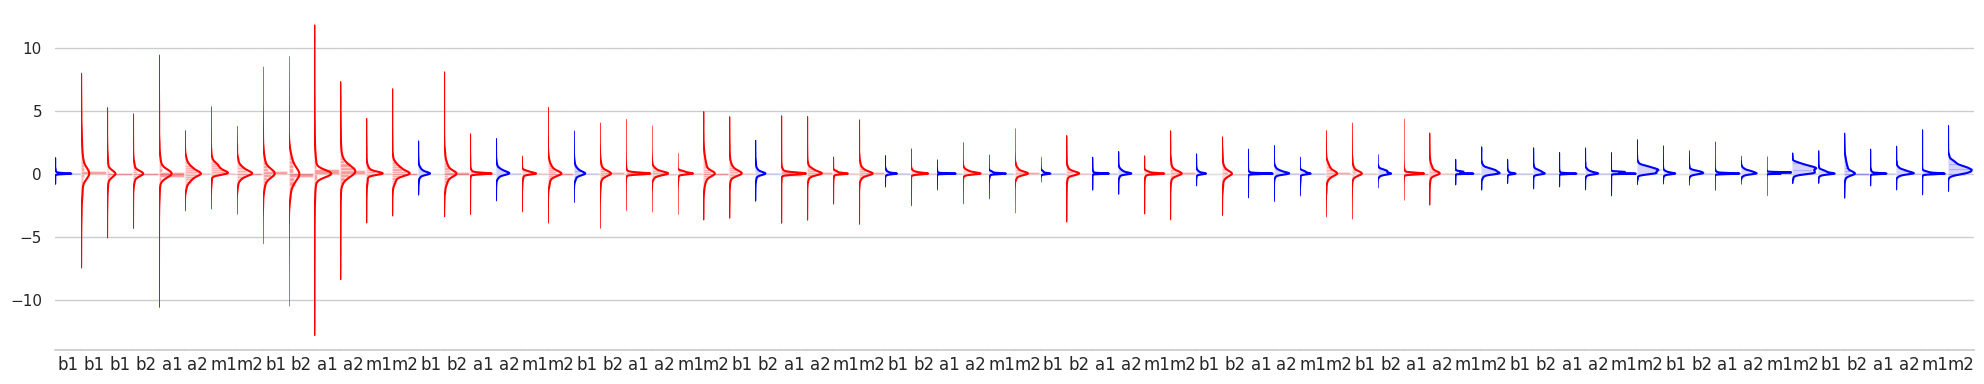

MAX Scale:  10.912936
MIN Scale:  -11.957451
AVE Scale:  0.0688380641881067
ssf_scale_1                    Len:  768   Max:1.145   Min:-0.717  Ave:0.034  Var:0.012
patch_embed.ssf_scale_1        Len:  768   Max:6.677   Min:-6.198  Ave:0.179  Var:2.481
blocks.0.ssf_scale_1           Len:  768   Max:4.458   Min:-4.321  Ave:-0.030  Var:0.878
blocks.0.ssf_scale_2           Len:  768   Max:4.138   Min:-3.747  Ave:0.047  Var:0.530
blocks.0.attn.ssf_scale_1      Len: 2304   Max:8.432   Min:-9.639  Ave:0.142  Var:2.189
blocks.0.attn.ssf_scale_2      Len:  768   Max:2.907   Min:-2.445  Ave:0.022  Var:0.366
blocks.0.mlp.ssf_scale_1       Len: 3072   Max:4.933   Min:-2.407  Ave:0.327  Var:0.351
blocks.0.mlp.ssf_scale_2       Len:  768   Max:3.225   Min:-2.704  Ave:0.105  Var:0.390
blocks.1.ssf_scale_1           Len:  768   Max:7.506   Min:-4.604  Ave:0.118  Var:1.384
blocks.1.ssf_scale_2           Len:  768   Max:7.892   Min:-9.100  Ave:-0.007  Var:3.033
blocks.1.attn.ssf_scale_1      Len: 2304  

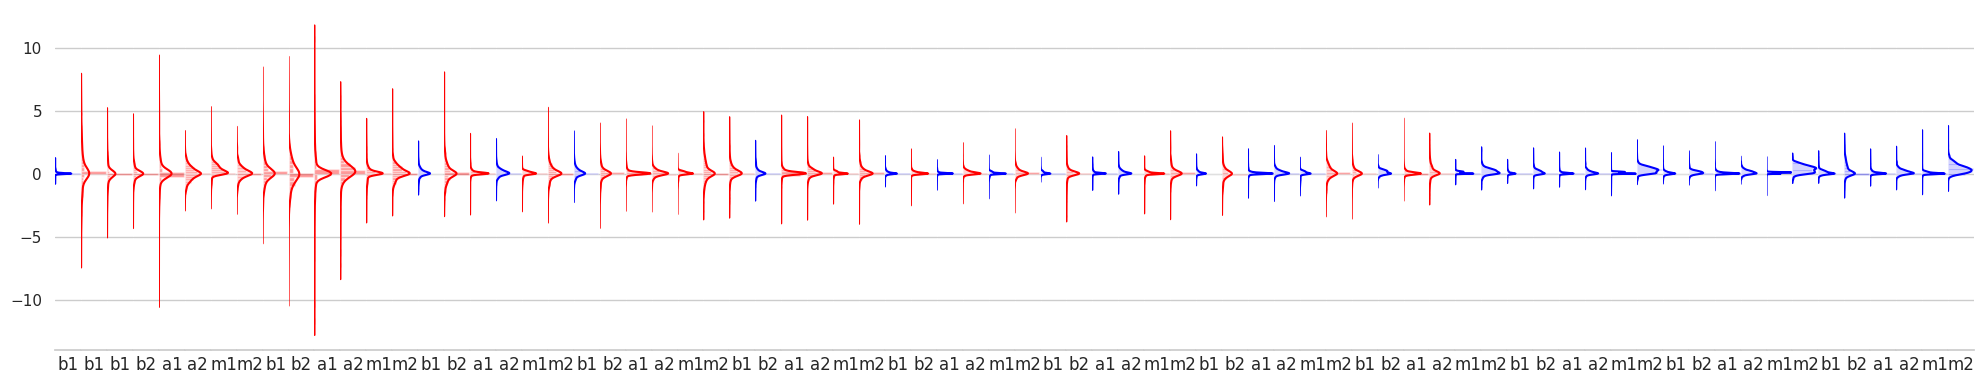

MAX Scale:  10.912936
MIN Scale:  -11.957451
AVE Scale:  0.07408689369203875
ssf_scale_1                    Len:  768   Max:1.145   Min:-0.717  Ave:0.034  Var:0.012
patch_embed.ssf_scale_1        Len:  768   Max:6.677   Min:-6.198  Ave:0.179  Var:2.481
blocks.0.ssf_scale_1           Len:  768   Max:4.458   Min:-4.321  Ave:-0.030  Var:0.878
blocks.0.ssf_scale_2           Len:  768   Max:4.138   Min:-3.747  Ave:0.047  Var:0.530
blocks.0.attn.ssf_scale_1      Len: 2288   Max:8.432   Min:-9.639  Ave:0.143  Var:2.204
blocks.0.attn.ssf_scale_2      Len:  768   Max:2.907   Min:-2.445  Ave:0.022  Var:0.366
blocks.0.mlp.ssf_scale_1       Len: 3067   Max:4.933   Min:-2.407  Ave:0.327  Var:0.352
blocks.0.mlp.ssf_scale_2       Len:  768   Max:3.225   Min:-2.704  Ave:0.105  Var:0.390
blocks.1.ssf_scale_1           Len:  768   Max:7.506   Min:-4.604  Ave:0.118  Var:1.384
blocks.1.ssf_scale_2           Len:  768   Max:7.892   Min:-9.100  Ave:-0.007  Var:3.033
blocks.1.attn.ssf_scale_1      Len: 2294 

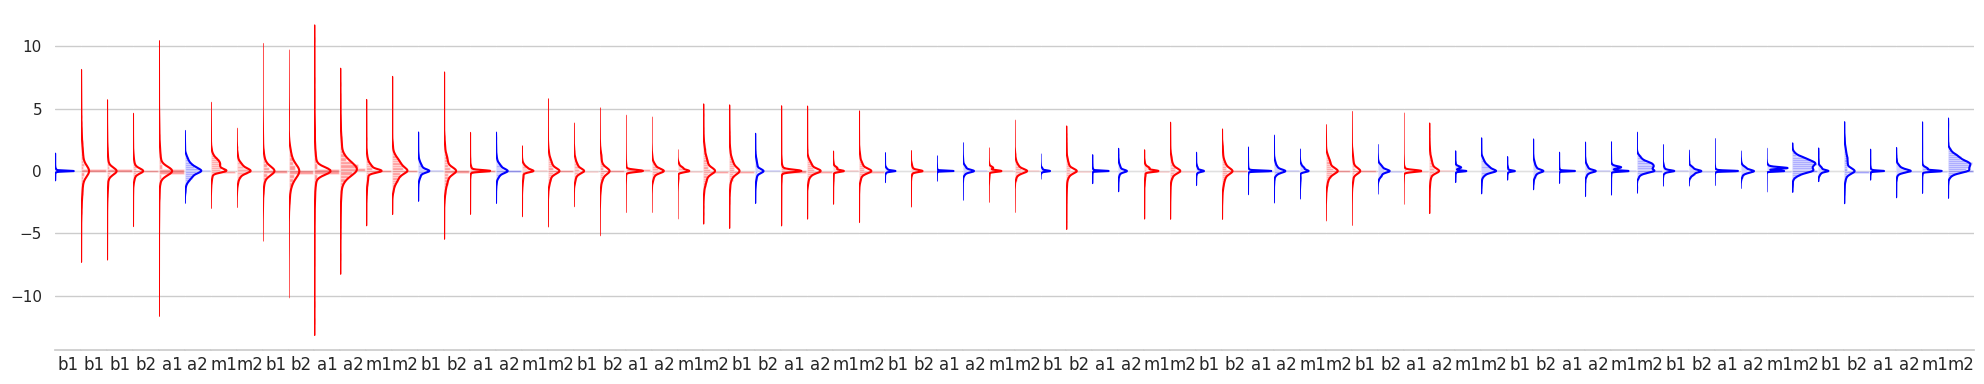

MAX Scale:  10.76842
MIN Scale:  -12.237313
AVE Scale:  0.08465003969637845
ssf_scale_1                    Len:  768   Max:1.319   Min:-0.669  Ave:0.013  Var:0.008
patch_embed.ssf_scale_1        Len:  768   Max:6.825   Min:-6.008  Ave:0.163  Var:2.560
blocks.0.ssf_scale_1           Len:  768   Max:4.850   Min:-6.266  Ave:-0.022  Var:1.068
blocks.0.ssf_scale_2           Len:  768   Max:4.016   Min:-3.841  Ave:0.047  Var:0.517
blocks.0.attn.ssf_scale_1      Len: 2304   Max:9.410   Min:-10.604  Ave:0.157  Var:2.461
blocks.0.attn.ssf_scale_2      Len:  768   Max:2.735   Min:-2.068  Ave:0.034  Var:0.370
blocks.0.mlp.ssf_scale_1       Len: 3072   Max:5.070   Min:-2.558  Ave:0.401  Var:0.449
blocks.0.mlp.ssf_scale_2       Len:  768   Max:2.901   Min:-2.392  Ave:0.093  Var:0.391
blocks.1.ssf_scale_1           Len:  768   Max:9.238   Min:-4.635  Ave:0.111  Var:1.436
blocks.1.ssf_scale_2           Len:  768   Max:8.244   Min:-8.703  Ave:-0.024  Var:3.222
blocks.1.attn.ssf_scale_1      Len: 2304 

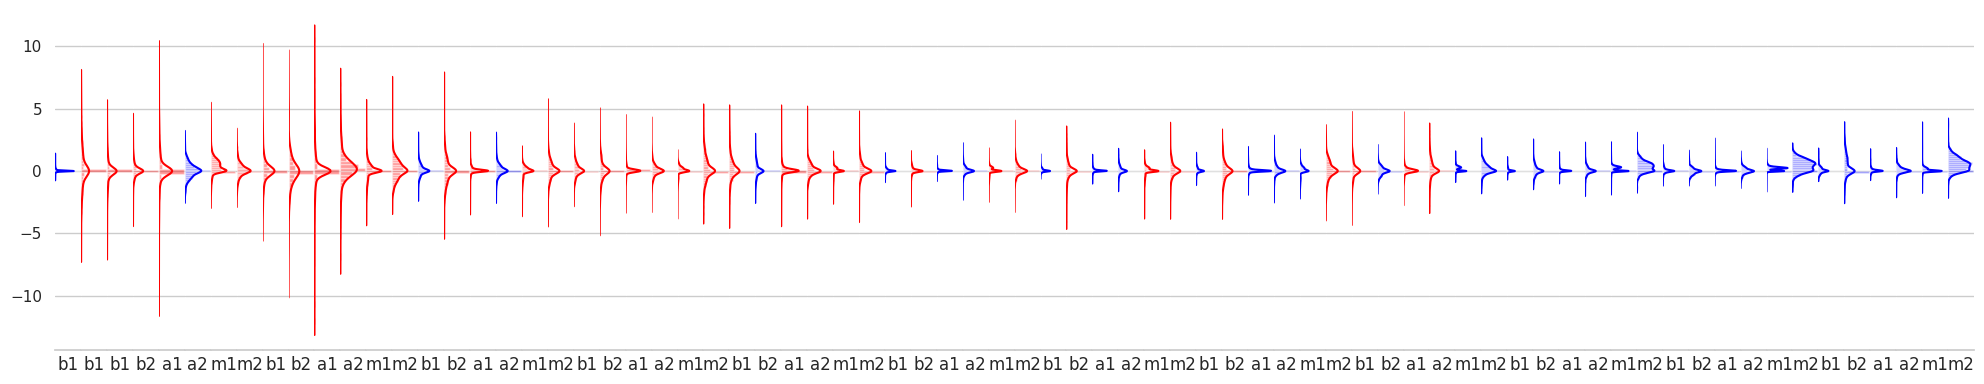

MAX Scale:  10.76842
MIN Scale:  -12.237313
AVE Scale:  0.09226041203132392
ssf_scale_1                    Len:  768   Max:1.319   Min:-0.669  Ave:0.013  Var:0.008
patch_embed.ssf_scale_1        Len:  768   Max:6.825   Min:-6.008  Ave:0.163  Var:2.560
blocks.0.ssf_scale_1           Len:  768   Max:4.850   Min:-6.266  Ave:-0.022  Var:1.068
blocks.0.ssf_scale_2           Len:  768   Max:4.016   Min:-3.841  Ave:0.047  Var:0.517
blocks.0.attn.ssf_scale_1      Len: 2298   Max:9.410   Min:-10.604  Ave:0.157  Var:2.467
blocks.0.attn.ssf_scale_2      Len:  768   Max:2.735   Min:-2.068  Ave:0.034  Var:0.370
blocks.0.mlp.ssf_scale_1       Len: 3067   Max:5.070   Min:-2.558  Ave:0.401  Var:0.450
blocks.0.mlp.ssf_scale_2       Len:  768   Max:2.901   Min:-2.392  Ave:0.093  Var:0.391
blocks.1.ssf_scale_1           Len:  768   Max:9.238   Min:-4.635  Ave:0.111  Var:1.436
blocks.1.ssf_scale_2           Len:  768   Max:8.244   Min:-8.703  Ave:-0.024  Var:3.222
blocks.1.attn.ssf_scale_1      Len: 2302 

In [13]:
print('==============================Reg+Rec======================')
draw_and_max_min_ave_var(cd_0)
print('==========================Reg+Rec  Masked==================')
draw_and_max_min_ave_var(cd_0_masked)
print('=========================Retrain_Full======================')
draw_and_max_min_ave_var(cd_1)
print('=========================Retrain_Full  Masked==============')
draw_and_max_min_ave_var(cd_1_masked)
print('===========================Retrain_Lora====================')
draw_and_max_min_ave_var(cd_2)
print('=======================Retrain_Lora  Masked================')
draw_and_max_min_ave_var(cd_2_masked)

In [93]:
print('==============================Reg+Rec======================')
max_min_ave_var(cd_0)
print('==========================Reg+Rec  Masked==================')
max_min_ave_var(cd_0_masked)
print('=========================Retrain_Full======================')
max_min_ave_var(cd_1)
print('=========================Retrain_Full  Masked==============')
max_min_ave_var(cd_1_masked)
print('===========================Retrain_Lora====================')
max_min_ave_var(cd_2)
print('=======================Retrain_Lora  Masked================')
max_min_ave_var(cd_2_masked)

==============================Reg+Rec======================
ssf_scale_1                    Len:  768   Max:0.886   Min:-0.000  Ave:0.197  Var:0.021
patch_embed.ssf_scale_1        Len:  768   Max:0.954   Min:-0.000  Ave:0.090  Var:0.022
blocks.0.ssf_scale_1           Len:  768   Max:1.252   Min:-0.000  Ave:0.100  Var:0.048
blocks.0.ssf_scale_2           Len:  768   Max:2.152   Min:-0.000  Ave:0.132  Var:0.052
blocks.0.attn.ssf_scale_1      Len: 2304   Max:1.398   Min:-0.000  Ave:0.106  Var:0.042
blocks.0.attn.ssf_scale_2      Len:  768   Max:1.606   Min:-0.000  Ave:0.200  Var:0.053
blocks.0.mlp.ssf_scale_1       Len: 3072   Max:1.380   Min:-0.022  Ave:0.109  Var:0.009
blocks.0.mlp.ssf_scale_2       Len:  768   Max:1.042   Min:-0.000  Ave:0.191  Var:0.041
blocks.1.ssf_scale_1           Len:  768   Max:1.385   Min:-0.000  Ave:0.080  Var:0.023
blocks.1.ssf_scale_2           Len:  768   Max:1.435   Min:-0.000  Ave:0.089  Var:0.018
blocks.1.attn.ssf_scale_1      Len: 2304   Max:0.931   Min:-

In [4]:
model = create_model(
        MODEL_NAME,
        pretrained=True,
        num_classes=NUM_CLASSES,
        drop_rate=0.0,
        drop_path_rate=0.0,
        drop_block_rate=None,
        global_pool=None,
        bn_momentum=None,
        bn_eps=None,
        scriptable=False,
        checkpoint_path='',
        tuning_mode=METHOD_NAME)
resume_epoch = resume_checkpoint(
    model, cd1,
    optimizer=None,
    loss_scaler=None,
    log_info=True)

In [4]:
# for i,(name,module) in enumerate(model.named_modules()) :
#     # print(name)
#     cw=False
#     for m in module.children():
#         if hasattr(m,"weight"):
#             cw=True
#     if cw:
#     # if hasattr(module,"weight"):
#         print(i,"\t",name)
#         print("PARAMETER: ")
#         for n,p in module.named_parameters():
#             print(n,"\t",p.shape)
#         print("DICT:")
#         # print(type(module.weight),module.weight.size())
#         for k in module.__dict__:
#             print("\t",k)
# for j,(name,parameters) in enumerate(model.named_parameters()):
#     key=["ssf_scale","ssf_scale"]
#     if any([k in name for k in key]):
#         print("{}\t{}\t{}\t{}".format(j,name,parameters.shape,parameters.data.shape))        
    

In [5]:
ssf_scale,ssf_shift={},{}
for name, para in model.named_parameters():
    if "ssf_scale" in name:
        ssf_scale[name]=para.data.detach().cpu().numpy()
    elif "ssf_shift" in name:
        ssf_shift[name]=para.data.detach().cpu().numpy()
    else:
        pass

In [6]:
# show basic info of ssf_scale and ssf_shift:
print("Length: ",len(ssf_scale),"\t",len(ssf_shift))
print("SSF_SCALE:")
for k in ssf_scale:
    print(k,ssf_scale[k].shape)
print("SSF_SHIFT:")
for k in ssf_shift:
    print(k,ssf_shift[k].shape)

Length:  74 	 74
SSF_SCALE:
ssf_scale_1 (768,)
patch_embed.ssf_scale_1 (768,)
blocks.0.ssf_scale_1 (768,)
blocks.0.ssf_scale_2 (768,)
blocks.0.attn.ssf_scale_1 (2304,)
blocks.0.attn.ssf_scale_2 (768,)
blocks.0.mlp.ssf_scale_1 (3072,)
blocks.0.mlp.ssf_scale_2 (768,)
blocks.1.ssf_scale_1 (768,)
blocks.1.ssf_scale_2 (768,)
blocks.1.attn.ssf_scale_1 (2304,)
blocks.1.attn.ssf_scale_2 (768,)
blocks.1.mlp.ssf_scale_1 (3072,)
blocks.1.mlp.ssf_scale_2 (768,)
blocks.2.ssf_scale_1 (768,)
blocks.2.ssf_scale_2 (768,)
blocks.2.attn.ssf_scale_1 (2304,)
blocks.2.attn.ssf_scale_2 (768,)
blocks.2.mlp.ssf_scale_1 (3072,)
blocks.2.mlp.ssf_scale_2 (768,)
blocks.3.ssf_scale_1 (768,)
blocks.3.ssf_scale_2 (768,)
blocks.3.attn.ssf_scale_1 (2304,)
blocks.3.attn.ssf_scale_2 (768,)
blocks.3.mlp.ssf_scale_1 (3072,)
blocks.3.mlp.ssf_scale_2 (768,)
blocks.4.ssf_scale_1 (768,)
blocks.4.ssf_scale_2 (768,)
blocks.4.attn.ssf_scale_1 (2304,)
blocks.4.attn.ssf_scale_2 (768,)
blocks.4.mlp.ssf_scale_1 (3072,)
blocks.4.mlp.s

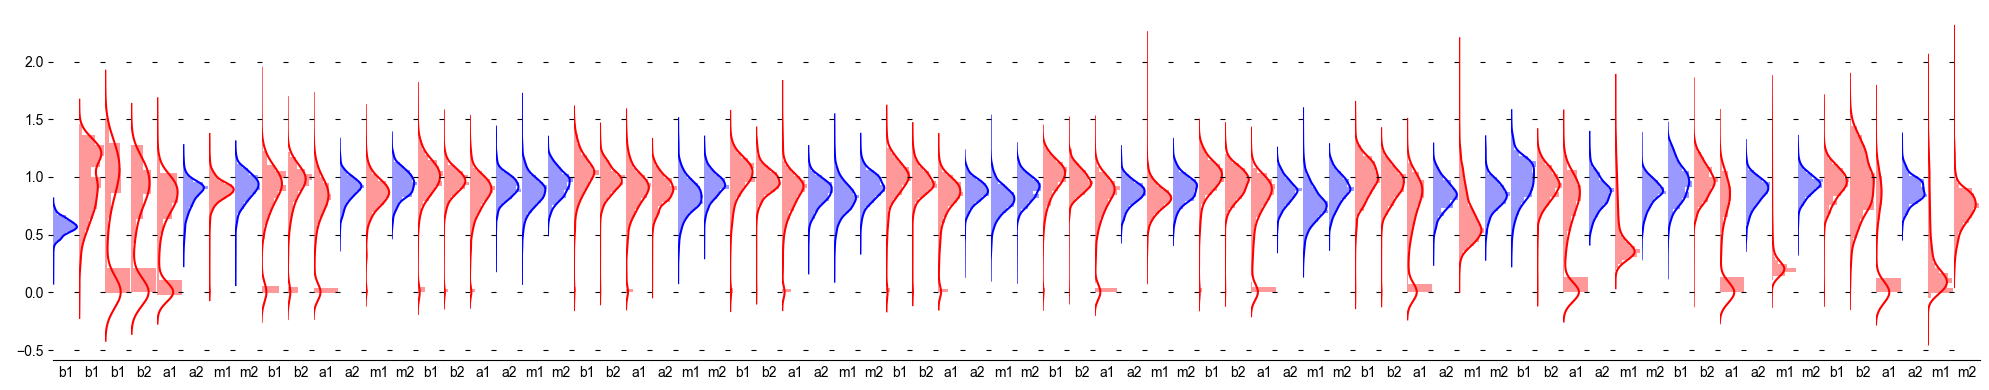

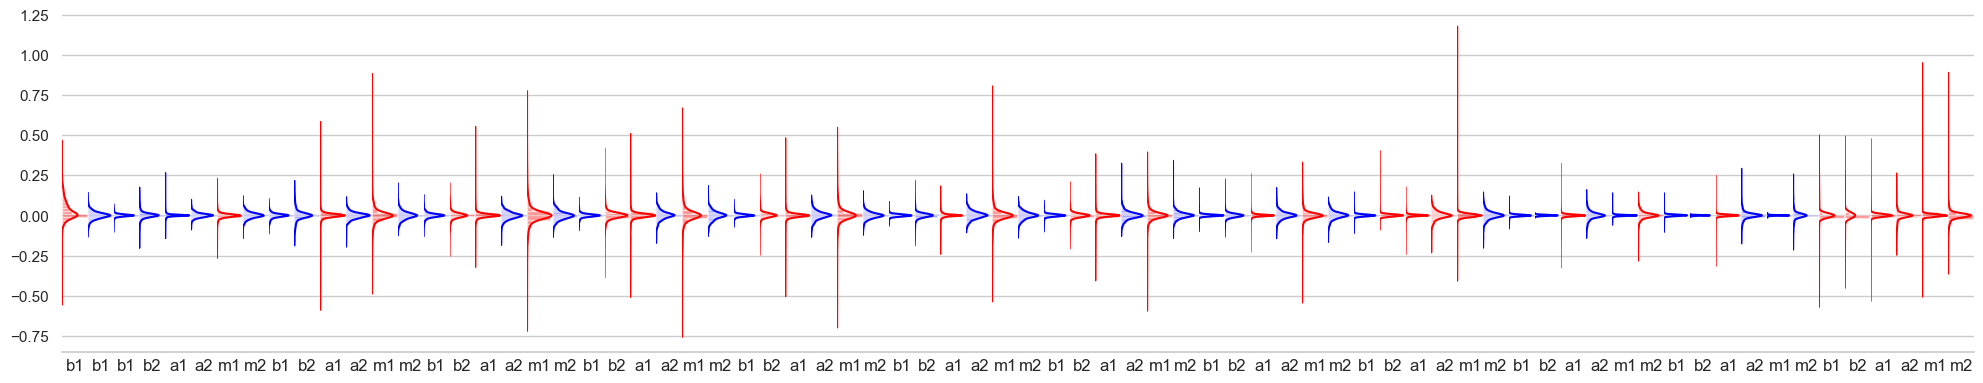

MAX Scale:  2.179944
MIN Scale:  -0.25891203
MAX Shift:  1.155549
MIN Shift:  -0.70795643


In [7]:
import warnings
warnings. filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision.models as models

def draw6(row1,name=None):
    data=row1
    arr = data
    up_mean=np.mean(np.array([a.max() for a in arr]))
    lw_mean=np.mean(np.array([a.min() for a in arr]))
    num_rows = len(arr)
    fig, axs = plt.subplots(ncols=num_rows, nrows=1, sharey=True,gridspec_kw={"hspace": 0, "wspace": 0})
    fig.set_size_inches(20, 4)
    lw=lw_mean*1.5 if lw_mean<0 else lw_mean*0.5
    ran=(lw,up_mean*1.5)
    ran=(lw,up_mean*1.5)
    for i in range(num_rows):
        # sns.histplot(y=arr[i], ax=axs[i], kde=True, stat="density")
        # sns.distplot(arr[i], ax=axs[i], kde=True, stat="density",hist_kws={'range': (0.0, 0.2)})
        color="blue"
        if arr[i].max() > up_mean*1.2 or arr[i].min() < lw_mean*0.8:
            color="red"
        sns.distplot(arr[i], ax=axs[i], kde=True, vertical=True,color=color)
        # sns.distplot(arr[i], ax=axs[i], kde=True, vertical=True,color=color,\
        #     hist_kws={'range': ran},kde_kws={'clip': ran})
        # sns.histplot(data, clip=(0, 10))
        axs[i].set_xticks([])
        # axs[i].set_xlabel(f"{i+1}")
        label=""
        if 'attn' in name[i]:
            label+="a"
        elif 'mlp' in name[i]:
            label+="m"
        else:
            label+="b"
        label+=name[i].split("_")[-1]
        axs[i].set_xlabel(label)
    plt.tight_layout()
    # sns.set_style('white')
    sns.set(style='whitegrid')
    sns.despine(right=True,left=True)
    plt.show()
ssf_scale_list,ssf_shift_list,ssf_scale_name,ssf_shift_name=[],[],[],[]
for name, para in model.named_parameters():
    if "ssf_scale" in name:
        ssf_scale_list.append(para.data.detach().cpu().numpy())
        ssf_scale_name.append(name)
    elif "ssf_shift" in name:
        ssf_shift_list.append(para.data.detach().cpu().numpy())
        ssf_shift_name.append(name)
    else:
        pass
draw6(ssf_scale_list,ssf_scale_name)
draw6(ssf_shift_list,ssf_shift_name)
print("MAX Scale: ", max([s.max() for s in ssf_scale_list]))
print("MIN Scale: ", min([s.min() for s in ssf_scale_list]))
print("MAX Shift: ", max([s.max() for s in ssf_shift_list]))
print("MIN Shift: ", min([s.min() for s in ssf_shift_list]))

In [8]:
# print("MIN Scale: ", min([s.min() for s in ssf_scale_list]))
# print("MAX Shift: ", max([s.max() for s in ssf_shift_list]))
sc_num=0
sc_pnm=0
for i,(sc,sh) in enumerate(zip(ssf_scale_list,ssf_shift_list)):
    # select indexes from sc, where abs value is less than 0.02
    # indexes=np.where(np.abs(sc)<0.02)
    indexes=np.argwhere(np.abs(sc)<0.01)
    subsc=np.take(sc,indexes)
    sc_pnm+=len(subsc)
    sc_num+=len(sc)
    subsh=np.take(sh,indexes)
    
    # subsh=np.take(sh,indexes)
    print("{:.2f} Layer {}:\t{}/{}\t{:.2f}%".format(np.abs(subsh).mean(), i,len(subsc),len(sc),len(subsc)/len(sc)*100))
print("Total:\t{}/{}\t{:.2f}%".format(sc_pnm,sc_num,sc_pnm/sc_num*100))

nan Layer 0:	0/768	0.00%
0.02 Layer 1:	2/768	0.26%
0.00 Layer 2:	266/768	34.64%
0.01 Layer 3:	246/768	32.03%
0.00 Layer 4:	576/2304	25.00%
nan Layer 5:	0/768	0.00%
0.00 Layer 6:	13/3072	0.42%
nan Layer 7:	0/768	0.00%
0.00 Layer 8:	78/768	10.16%
0.01 Layer 9:	53/768	6.90%
0.00 Layer 10:	358/2304	15.54%
nan Layer 11:	0/768	0.00%
0.00 Layer 12:	23/3072	0.75%
nan Layer 13:	0/768	0.00%
0.00 Layer 14:	26/768	3.39%
0.03 Layer 15:	16/768	2.08%
0.00 Layer 16:	46/2304	2.00%
nan Layer 17:	0/768	0.00%
nan Layer 18:	0/3072	0.00%
nan Layer 19:	0/768	0.00%
0.01 Layer 20:	7/768	0.91%
0.00 Layer 21:	3/768	0.39%
0.00 Layer 22:	58/2304	2.52%
nan Layer 23:	0/768	0.00%
nan Layer 24:	0/3072	0.00%
nan Layer 25:	0/768	0.00%
0.00 Layer 26:	11/768	1.43%
0.03 Layer 27:	2/768	0.26%
0.00 Layer 28:	84/2304	3.65%
nan Layer 29:	0/768	0.00%
nan Layer 30:	0/3072	0.00%
nan Layer 31:	0/768	0.00%
0.00 Layer 32:	15/768	1.95%
0.01 Layer 33:	5/768	0.65%
0.00 Layer 34:	88/2304	3.82%
nan Layer 35:	0/768	0.00%
nan Layer 36:	0/3

In [9]:
# def print_outler(row1,name=None):
#     data=row1
#     arr = data
#     up_mean=np.mean(np.array([a.max() for a in arr]))
#     lw_mean=np.mean(np.array([a.min() for a in arr]))
#     num_rows = len(arr)
#     lw=lw_mean*1.5 if lw_mean<0 else lw_mean*0.5
#     ran=(lw,up_mean*1.5)
#     for i in range(len(row1)):
#         if arr[i].max() > up_mean*1.2 or arr[i].min() < lw_mean*0.8:
#             print(name[i])
# print_outler(ssf_scale_list,ssf_scale_name)
# print_outler(ssf_shift_list,ssf_shift_name)


# 运行计时
5.23 00:35 开始运行 ./train_scripts/vit/cifar_vtab

In [ ]:
def get_scale_list(path):
    model = create_model(
        MODEL_NAME,
        pretrained=True,
        num_classes=NUM_CLASSES,
        drop_rate=0.0,
        drop_path_rate=0.0,
        drop_block_rate=None,
        global_pool=None,
        bn_momentum=None,
        bn_eps=None,
        scriptable=False,
        checkpoint_path='',
        tuning_mode=METHOD_NAME)
    resume_epoch = resume_checkpoint(
        model, path,
        optimizer=None,
        loss_scaler=None,
        log_info=True)
    
    ssf_scale,ssf_scale_masked=[],[]
    for name, para in model.named_parameters():
        if "ssf_scale" in name:
            temp=para.data.detach().cpu().numpy()
            ssf_scale.append(temp)
            ssf_scale_masked.append(temp[temp!=0])
    
    return  ssf_scale,ssf_scale_masked

In [ ]:
def draw(dict):
    arr,name=[],[]
    for key,val in dict.items():
        name.append(key)
        arr.append(val)
    up_mean=np.mean(np.array([a.max() for a in arr]))
    lw_mean=np.mean(np.array([a.min() for a in arr]))
    num_rows = len(arr)
    fig, axs = plt.subplots(ncols=num_rows, nrows=1, sharey=True,gridspec_kw={"hspace": 0, "wspace": 0})
    fig.set_size_inches(20, 4)
    lw=lw_mean*1.5 if lw_mean<0 else lw_mean*0.5
    ran=(lw,up_mean*1.5)
    ran=(lw,up_mean*1.5)
    for i in range(num_rows):
        # sns.histplot(y=arr[i], ax=axs[i], kde=True, stat="density")
        # sns.distplot(arr[i], ax=axs[i], kde=True, stat="density",hist_kws={'range': (0.0, 0.2)})
        color="blue"
        if arr[i].max() > up_mean*1.2 or arr[i].min() < lw_mean*0.8:
            color="red"
        sns.distplot(arr[i], ax=axs[i], kde=True, vertical=True,color=color)
        # sns.distplot(arr[i], ax=axs[i], kde=True, vertical=True,color=color,\
        #     hist_kws={'range': ran},kde_kws={'clip': ran})
        # sns.histplot(data, clip=(0, 10))
        axs[i].set_xticks([])
        # axs[i].set_xlabel(f"{i+1}")
        label=""
        if 'attn' in name[i]:
            label+="a"
        elif 'mlp' in name[i]:
            label+="m"
        else:
            label+="b"
        label+=name[i].split("_")[-1]
        axs[i].set_xlabel(label)
    plt.tight_layout()
    # sns.set_style('white')
    sns.set(style='whitegrid')
    sns.despine(right=True,left=True)
    plt.show()
    print("MAX Scale: ", max([s.max() for s in arr]))
    print("MIN Scale: ", min([s.min() for s in arr]))
    print("AVE Scale: ", sum([sum(s) for s in arr])/sum([len(s) for s in arr]))

In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(161)
draw(cd_0)
plt.title('0')
plt.subplot(162)
draw(cd_0_masked)
plt.title('0_masked')
plt.subplot(163)
draw(cd_1)
plt.title('1')
plt.subplot(164)
draw(cd_1_masked)
plt.title('1_masked')
plt.subplot(165)
draw(cd_2)
plt.title('2')
plt.subplot(166)
draw(cd_2_masked)
plt.title('2_masked')
plt.show()

In [ ]:
def draw1():
    sarr,arr,name=[],[],[]
    for dict in [cd_0,cd_0_masked,cd_1,cd_1_masked,cd_2,cd_2_masked]:
        for key,val in dict.items():
            name.append(key)
            arr.append(val)
        sarr.append(arr)
    up_mean=np.mean(np.array([a.max() for a in arr]))
    lw_mean=np.mean(np.array([a.min() for a in arr]))
    num_rows = len(arr)
    rows=6
    fig, axs = plt.subplots(ncols=num_rows, nrows=6, sharey=True,gridspec_kw={"hspace": 0, "wspace": 0})
    fig.set_size_inches(20, 4)
    lw=lw_mean*1.5 if lw_mean<0 else lw_mean*0.5
    ran=(lw,up_mean*1.5)
    ran=(lw,up_mean*1.5)
    for j in range(rows):
        arr=sarr[j]
        for i in range(num_rows):
            color="blue"
            if arr[i].max() > up_mean*1.2 or arr[i].min() < lw_mean*0.8:
                color="red"
            sns.distplot(arr[i], ax=axs[i,j], kde=True, vertical=True,color=color)
            axs[i,j].set_xticks([])
            label=""
            if 'attn' in name[i]:
                label+="a"
            elif 'mlp' in name[i]:
                label+="m"
            else:
                label+="b"
            label+=name[i].split("_")[-1]
            axs[i,j].set_xlabel(label)
        break
    plt.tight_layout()
    # sns.set_style('white')
    sns.set(style='whitegrid')
    sns.despine(right=True,left=True)
    plt.show()
    print("MAX Scale: ", max([s.max() for s in arr]))
    print("MIN Scale: ", min([s.min() for s in arr]))
    print("AVE Scale: ", sum([sum(s) for s in arr])/sum([len(s) for s in arr]))
draw1()